In [ ]:
!git clone https://github.com/bubbliiiing/pspnet-pytorch.git
!git clone https://github.com/frasergmasson/pytorch-segmentation-utils.git
%cd pspnet-pytorch

!cp ../pytorch-segmentation-utils/*.py .

Cloning into 'pspnet-pytorch'...
remote: Enumerating objects: 372, done.
remote: Counting objects: 100% (100/100), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 372 (delta 78), reused 82 (delta 66), pack-reused 272
Receiving objects: 100% (372/372), 9.28 MiB | 6.13 MiB/s, done.
Resolving deltas: 100% (215/215), done.
Cloning into 'pytorch-segmentation-utils'...
remote: Enumerating objects: 83, done.
remote: Counting objects: 100% (83/83), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 83 (delta 49), reused 61 (delta 27), pack-reused 0
Unpacking objects: 100% (83/83), 10.03 KiB | 570.00 KiB/s, done.
/content/pspnet-pytorch


In [ ]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!cp /content/drive/MyDrive/3rdYear/Project/Data/masks.zip .
!cp /content/drive/MyDrive/3rdYear/Project/Data/images.zip .
!unzip masks.zip >> /dev/null
!unzip images.zip >> /dev/null

In [ ]:
!mkdir /content/generated-masks

In [ ]:
from nets.pspnet import PSPNet
from pair_transform import PairTransform, FunctionalPairTransform
from evaluation import pixel_accuracy,tp_ap_all_classes,in_union_all_classes, \
  tp_fp_fn_all_classes, confusions, MetricManager
from dataset import ImageMaskDataset
from mask_to_img import mask_to_img
from weights import calculate_class_weights
import os
from torchvision.io import read_image
import torch.utils.data as tdata
import torchvision.transforms as transforms
import torchvision.transforms.functional as f_transforms
from torchinfo import summary
import torch
import torch.nn as nn
import imageio
import numpy as np
import matplotlib.pyplot as plt
from math import ceil,floor
from functools import partial
import random
import torch.nn.functional as F
import cv2
import pickle

In [ ]:
def random_k_split(k,n):
  available_indices = list(range(n))
  random.shuffle(available_indices)

  return np.array_split(available_indices,k)

## Train Loop function

In [ ]:
def train(train_loader,test_loader,epochs,metrics,device):
  model = PSPNet(num_classes=n_labels,downsample_factor=16)
  #Train loop
  model.to(device)
  n_batches = len(train_loader)

  criterion = nn.CrossEntropyLoss(weight= calculate_class_weights(train_set,n_labels,device=device))
  optimiser = torch.optim.Adam(model.parameters())
  scheduler = torch.optim.lr_scheduler.OneCycleLR(
      optimiser,
      max_lr =0.002,
      epochs = epochs,
      steps_per_epoch= n_batches,
      anneal_strategy="cos"
  )

  epoch_losses = []
  test_losses = []
  for epoch in range(epochs):
      #Train
      epoch_loss = 0
      model.train()
      for images,masks in train_loader:
          optimiser.zero_grad()
          images = images.to(device)
          masks = masks.to(device)

          predicted = model(images)
          loss = criterion(predicted[0],masks)
          loss.backward()
          optimiser.step()
          scheduler.step()

          epoch_loss += loss.item()

      epoch_loss = epoch_loss/n_batches
      epoch_losses.append(epoch_loss)

      #Evaluate
      model.eval()
      test_loss = 0
      for _,images,masks in test_loader:
        images = images.to(device)
        masks = masks.to(device)
        predicted_masks = model(images)[0]

        metrics.apply_metrics(predicted_masks,masks)
        test_loss += criterion(predicted_masks,masks).item()


      test_loss = test_loss/len(test_loader)
      test_losses.append(test_loss)

      if epoch % 20 == 0:
        print(f"[{epoch+1}/{epochs}] Training loss: {epoch_loss}")
        print(f"Testing loss: {test_loss}")
  return model,epoch_losses, test_losses

In [ ]:
label_colours = {
    0 : [255,0,255],
    1 : [0,255,0],
    2 : [0,0,255],
    3 : [255,0,0],
    4 : [255,255,255],
    5 : [0,0,0]
}

In [ ]:
def change_file_type(filename,extension):
  return filename[:-4] + "." + extension
def evaluate(model,test_loader,metrics,device,output_dir=None):
  model.eval()
  #Apply metrics
  for fnames,images,masks in test_loader:
        images = images.to(device)
        masks = masks.to(device)
        predicted_masks = model(images)[0]

        metrics.apply_metrics(predicted_masks,masks)

        #Save masks to disk
        if output_dir:
          for i,predicted_mask in enumerate(predicted_masks):
            colour_mask = mask_to_img(predicted_mask,label_colours)
            cv2.imwrite(os.path.join(output_dir,
                        change_file_type(fnames[i],"png")),
                        colour_mask)

## Real life code

In [ ]:
n_labels = 6
image_size = (400,600)

batch_size = 9
epochs = 200

results_file = "/content/results.pkl"

In [ ]:
pair_transforms =[
  PairTransform(
    transforms.RandomResizedCrop,
    f_transforms.resized_crop,
    0.2,
    {"img":torch.zeros(image_size),
    "scale":(0.6, 1.0),
    "ratio":(0.75, 1.3333333333333333)},
    {"size":image_size}
  ),
  PairTransform(
      transforms.RandomRotation,
      f_transforms.rotate,
      0.2,
      {"degrees":[-20,20]}
  ),
  FunctionalPairTransform(
      f_transforms.hflip,
      0.2
  )
]

colour_transforms = transforms.Compose([
    transforms.RandomApply([
        transforms.ColorJitter(brightness=.5, hue=.3,contrast=.3,saturation=0.2)], 0.2)
])

In [ ]:
class TaggedDataset(ImageMaskDataset):
  def __getitem__(self,idx):
    image,mask = super(TaggedDataset,self).__getitem__(idx)
    image_file_name = self.image_names[idx]
    return image_file_name,image,mask

In [ ]:
dataset = ImageMaskDataset("data/imgs","data/masks","_mask",colour_transforms,pair_transforms)
#Dataset without augmentation is used for evaluation
no_augment_dataset = TaggedDataset("data/imgs","data/masks","_mask")
print(len(dataset))

54


In [ ]:
labels = [
    "glacier",
    "iceberg",
    "growler",
    "sea",
    "sky",
    "background"
]
def create_metric_managers():
  metrics = MetricManager(labels)
  metrics.add_metric("pa",pixel_accuracy)
  metrics.add_metric("tp_ap",tp_ap_all_classes,n_labels=n_labels)
  metrics.add_metric("intersect_union",in_union_all_classes,n_labels=n_labels)
  metrics.add_metric("tp_fp_fn",tp_fp_fn_all_classes,n_labels=n_labels)

  test_metrics = MetricManager(labels)
  test_metrics.add_metric("pa",pixel_accuracy)
  test_metrics.add_metric("tp_ap",tp_ap_all_classes,n_labels=n_labels)
  test_metrics.add_metric("intersect_union",in_union_all_classes,n_labels=n_labels)
  test_metrics.add_metric("tp_fp_fn",tp_fp_fn_all_classes,n_labels=n_labels)
  test_metrics.add_metric("confusions",confusions,n_labels=n_labels)
  return metrics,test_metrics

In [ ]:
k = 6
splits = random_k_split(k,len(dataset))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

output_dic = {
  "k": 0,
  "splits" : splits,
  "train_losses" : [],
  "test_losses" : [],
  "train_tp_fp_fn" : [],
  "train_tp_ap" : [],
  "train_pas" : [],
  "train_in_union" : [],
  "test_tp_fp_fn" : [],
  "test_tp_ap" : [],
  "test_pas" : [],
  "test_in_union" : [],
  "test_confusions":[]
}

if os.path.isfile(results_file):
  #Load stuff from file
  with open(results_file,"rb") as f:
    output_dic = pickle.load(f)

start_split = output_dic["k"]
#If run is saved use splits from that
splits = output_dic["splits"]

#K fold loop
for i in range(start_split,k):
  print(f"Starting run {i+1}.")
  test_set = torch.utils.data.Subset(no_augment_dataset,splits[i])
  train_indices = [item for sublist in splits[0:i]+splits[i+1:] for item in sublist]
  train_set = torch.utils.data.Subset(dataset,train_indices)

  train_loader = tdata.DataLoader(train_set,batch_size=batch_size,drop_last=True,shuffle=True)
  test_loader = tdata.DataLoader(test_set,batch_size=batch_size,drop_last=True,shuffle=True)

  metrics,test_metrics = create_metric_managers()

  model, train_loss, test_loss = train(train_loader,test_loader,epochs,metrics,device)
  evaluate(model,test_loader,test_metrics,device,output_dir="/content/generated-masks")

  output_dic["train_losses"].append(train_loss)
  output_dic["test_losses"].append(test_loss)

  output_dic["train_tp_fp_fn"].append(metrics.get_metric("tp_fp_fn"))
  output_dic["train_in_union"].append(metrics.get_metric("intersect_union"))
  output_dic["train_tp_ap"].append(metrics.get_metric("tp_ap"))
  output_dic["train_pas"].append(metrics.get_metric("pa"))

  output_dic["test_tp_fp_fn"].append(test_metrics.get_metric("tp_fp_fn"))
  output_dic["test_in_union"].append(test_metrics.get_metric("intersect_union"))
  output_dic["test_tp_ap"].append(test_metrics.get_metric("tp_ap"))
  output_dic["test_pas"].append(test_metrics.get_metric("pa"))
  output_dic["test_confusions"].append(test_metrics.get_metric("confusions"))
  output_dic["k"] = i+1

  #Save results after each run
  with open(results_file,"wb") as f:
    pickle.dump(output_dic,f)

  !cp "/content/results.pkl" "/content/drive/MyDrive/3rdYear/Project/Data/"
  !mv /content/generated-masks/* /content/drive/MyDrive/3rdYear/Project/Data/generated-masks

  print(f"Run {i+1} complete!")

Starting run 1.


Downloading: "https://github.com/bubbliiiing/pspnet-pytorch/releases/download/v1.0/resnet50s-a75c83cf.pth" to ./model_data/resnet50s-a75c83cf.pth
100%|██████████| 98.2M/98.2M [00:00<00:00, 262MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[1/200] Training loss: 12.795583724975586
Testing loss: 13.032405853271484
[21/200] Training loss: 4.674033880233765
Testing loss: 4.101904392242432
[41/200] Training loss: 4.990269303321838
Testing loss: 9.492683410644531
[61/200] Training loss: 4.622903764247894
Testing loss: 3.013324022293091
[81/200] Training loss: 4.059857666492462
Testing loss: 3.84609317779541
[101/200] Training loss: 2.6122214794158936
Testing loss: 3.1662421226501465
[121/200] Training loss: 3.022503837943077
Testing loss: 2.6720309257507324
[141/200] Training loss: 2.9435301423072815
Testing loss: 1.9878017902374268
[161/200] Training loss: 2.3108799308538437
Testing loss: 2.878208875656128
[181/200] Training loss: 4.1048808097839355
Testing loss: 2.8819708824157715
Run 1 complete!
Starting run 2.
[1/200] Training loss: 9.402369976043701
Testing loss: 11.98171615600586
[21/200] Training loss: 2.2208251953125
Testing loss: 3.9309332370758057
[41/200] Training loss: 4.343013286590576
Testing loss: 4.46346473693

In [ ]:
with open("results.pkl",'wb') as f:
  pickle.dump(output_dic,f)

In [ ]:
with open("results.pkl",'rb') as f:
  results = pickle.load(f)

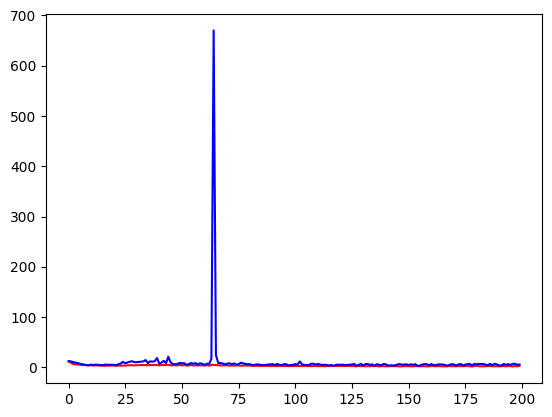

In [ ]:
plt.plot(np.mean(results["train_losses"],0),c="red")
plt.plot(np.mean(results["test_losses"],0),c="blue")